# Base Matrix Factorisation

In [24]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import torch
from tdc.multi_pred import DTI
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import logging
from rdkit import Chem

Found local copy...
Loading...
Done!
To log space...


## Data Loading

In [ ]:
# load in the Kd dataset
# method also works with IC50 and Ki datasets
data = DTI(name = 'BindingDB_Kd')
data.convert_to_log(form = 'binding')

## Data pre-processing

In [25]:
def data_split(data):
    # split data using tdc modules random split using default 0.7, 0.1, 0.2 split
    split = data.get_split(seed = 42)
    train = split['train']
    test = split['test']

    # enumerate drugs and targets for easy indexing
    ID_to_Drug = dict(enumerate(list(dict.fromkeys(train['Drug']))))
    ID_to_Target = dict(enumerate(list(dict.fromkeys(train['Target']))))
    Drug_to_ID = dict((v,k) for k,v in ID_to_Drug.items())
    Target_to_ID = dict((v,k) for k,v in ID_to_Target.items())
    
    return train, test, Drug_to_ID, Target_to_ID

def data_loader(data, drug_dict, target_dict):
    # allows data to be correctly passed in to PyTorch DataLoader
    
    # apply ID dictionary to both drugs and targets
    data["Drug_DictID"] = data["Drug"].apply(lambda x:drug_dict.get(x))
    data["Target_DictID"] = data["Target"].apply(lambda x:target_dict.get(x))

    # convert data into expected data types
    drug_ID = data["Drug_DictID"].to_numpy()
    target_ID = data["Target_DictID"].to_numpy()
    features = np.vstack((drug_ID, target_ID)).T
    label = data['Y'].to_numpy()
    return features, label

## Pytorch Matrix Factorisation model
Code for the base model including `MatrixFactorisation` class and the `train_model` function was obtained and optimised from a [Medium article](https://medium.com/@rinabuoy13/explicit-recommender-system-matrix-factorization-in-pytorch-f3779bb55d74)

In [ ]:
class RatingDataset(Dataset):
    def __init__(self, train, label):
        self.feature_= train
        self.label_= label
    def __len__(self):
    #return size of dataset
        return len(self.feature_)
    def __getitem__(self, idx):
        return  torch.tensor(self.feature_[idx], dtype=torch.long),torch.tensor(self.label_[idx], dtype=torch.float)
    
    
class MatrixFactorization(torch.nn.Module):
    
    def __init__(self, n_users, n_items, n_factors):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        torch.nn.init.xavier_uniform_(self.user_factors.weight)
        torch.nn.init.xavier_uniform_(self.item_factors.weight)
        
        self.user_biases = torch.nn.Embedding(n_users, 1)
        self.item_biases = torch.nn.Embedding(n_items,1)
        self.user_biases.weight.data.fill_(0.)
        self.item_biases.weight.data.fill_(0.)

        
    def forward(self, user, item):  
        pred = self.user_biases(user) + self.item_biases(item)
        pred += (self.user_factors(user) * self.item_factors(item)).sum(1, keepdim=True)
        return pred.squeeze()

In [32]:
def train_model(train_loader, test_loader, model, num_epochs=100):
    dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    loss_func = torch.nn.MSELoss()
    
    model.to(dev)
    
    train_losses = []
    test_losses = []
    for epoch in range(0,num_epochs):
        count = 0
        cum_loss = 0.
        for i, (train_batch, label_batch) in enumerate(train_loader):
            count = 1 + i
            # Predict and calculate loss for user factor and bias
            optimizer = torch.optim.SGD([model.user_biases.weight,model.user_factors.weight, 
                                         model.item_biases.weight,model.item_factors.weight], 
                                        lr=0.05, weight_decay=1e-5)
            prediction = model(train_batch[:,0].to(dev), train_batch[:,1].to(dev))
            loss = loss_func(prediction, label_batch.to(dev)).float()    
            loss_item = loss.item()
            cum_loss += loss_item

            # Backpropagate
            loss.backward()

            # Update the parameters
            optimizer.step()
            optimizer.zero_grad()
            
        train_loss = cum_loss/count
        train_losses.append(train_loss)

        cum_loss =0.
        count = 0
        for i, (test_batch, label_batch) in enumerate(test_loader):
            count = 1 + i
            with torch.no_grad():
                prediction = model(test_batch[:,0].to(dev), test_batch[:,1].to(dev))
                loss = loss_func(prediction, label_batch.to(dev))
                cum_loss += loss.item()

        test_loss = cum_loss/count
        test_losses.append(test_loss)
        if epoch % 5 == 0:
            print('epoch: ', epoch ,' avg training loss: ', train_loss, ' avg test loss: ',test_loss)
    return train_losses, test_losses

## Training and Evaluation

In [33]:
def full_model(data, img_name, n_factors=100, bs=100, num_epochs=100):
    train, test, drug_dict, target_dict = data_split(data)
    x_train, y_train = data_loader(train, drug_dict, target_dict)
    x_test, y_test = data_loader(test, drug_dict, target_dict)

    train_dataloader = DataLoader(RatingDataset(x_train, y_train), batch_size=bs, shuffle=True)
    test_dataloader = DataLoader(RatingDataset(x_test, y_test), batch_size=bs)
    
    model = MatrixFactorization(len(drug_dict), len(target_dict), n_factors)

    train_losses, test_losses = train_model(train_dataloader, test_dataloader, model, num_epochs)

    epochs = range(1, num_epochs+1)
    plt.plot(epochs, train_losses, label='train')
    plt.plot(epochs, test_losses, label='test')
    plt.xlabel('epoch')
    plt.ylabel('mse loss')
    plt.legend()
    plt.title(img_name)
#     plt.savefig(img_name)
    plt.show()

epoch:  0  avg training loss:  28.744022119240682  avg test loss:  22.55029754638672
epoch:  5  avg training loss:  9.412281089793138  avg test loss:  8.827154241289412
epoch:  10  avg training loss:  6.965915761358751  avg test loss:  6.678426740283058
epoch:  15  avg training loss:  5.771433572300145  avg test loss:  5.594168583552043
epoch:  20  avg training loss:  4.981215626164213  avg test loss:  4.873431148983183
epoch:  25  avg training loss:  4.374695274673525  avg test loss:  4.320157057898385
epoch:  30  avg training loss:  3.8671086463120465  avg test loss:  3.860383331208002
epoch:  35  avg training loss:  3.4514322684762258  avg test loss:  3.4833404336656844
epoch:  40  avg training loss:  3.11649142295285  avg test loss:  3.180008106004624
epoch:  45  avg training loss:  2.8455047032546474  avg test loss:  2.936517852828616
epoch:  50  avg training loss:  2.622966352381993  avg test loss:  2.739274208886283
epoch:  55  avg training loss:  2.4368798612245444  avg test lo

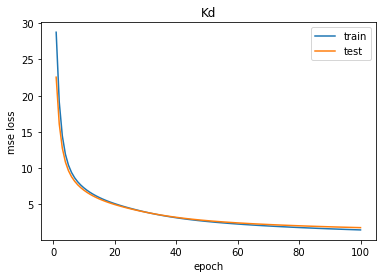

In [34]:
full_model(data_Kd, 'Kd', n_factors=20, bs=100, num_epochs=100)